In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE

# For balancing classes
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras

import os

2025-05-27 06:09:15.358529: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 06:09:15.583110: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 06:09:15.885837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748308156.359033  212197 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748308156.421595  212197 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748308157.054276  212197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
DATA_PATH = 'df.csv'

df = pd.read_csv(DATA_PATH)

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")
print(f"Missing values:\n{df.isnull().sum()}")

Original dataset shape: (10000, 25)
Columns: ['Passenger_ID', 'Flight_ID', 'Airline', 'Departure_Airport', 'Arrival_Airport', 'Departure_Time', 'Flight_Duration_Minutes', 'Flight_Status', 'Distance_Miles', 'Price_USD', 'Age', 'Gender', 'Income_Level', 'Travel_Purpose', 'Seat_Class', 'Bags_Checked', 'Frequent_Flyer_Status', 'Check_in_Method', 'Flight_Satisfaction_Score', 'Delay_Minutes', 'Booking_Days_In_Advance', 'No_Show', 'Weather_Impact', 'Seat_Selected', 'Booking_Lead_Time']
Data types:
Passenger_ID                  object
Flight_ID                     object
Airline                       object
Departure_Airport             object
Arrival_Airport               object
Departure_Time                object
Flight_Duration_Minutes        int64
Flight_Status                 object
Distance_Miles                 int64
Price_USD                    float64
Age                            int64
Gender                        object
Income_Level                  object
Travel_Purpose         

In [3]:
# --- PREPROCESSING ---
id_cols = ["Passenger_ID", "Flight_ID"]
df = df.drop(columns=id_cols, errors='ignore')

# Target variable (example: classify On-time, Delayed, Cancelled)
TARGET = "Flight_Status"
df = df[df[TARGET].isin(["On-time", "Delayed", "Cancelled"])]

In [4]:
# Split features/target
X = df.drop(columns=[TARGET])
y = df[TARGET]

In [16]:
# Encode categorical columns
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col] = X[col].fillna('NA')
    enc = LabelEncoder()
    X[col] = enc.fit_transform(X[col].astype(str))

print(f"Categorical columns encoded: {list(cat_cols)}")
print(f"Features after encoding - shape: {X.shape}")

Categorical columns encoded: []
Features after encoding - shape: (10000, 22)


In [6]:
# Fill missing numerics
X = X.fillna(X.median(numeric_only=True))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

print(f"Final features shape: {X_scaled.shape}")

Final features shape: (10000, 22)


In [7]:
# --- TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ADDRESS CLASS IMBALANCE (SMOTE)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"Train set before SMOTE: {X_train.shape}")
print(f"Train set after SMOTE: {X_train_bal.shape}")

Train set before SMOTE: (8000, 22)
Train set after SMOTE: (19194, 22)


Shape of PCA components: (10, 22)


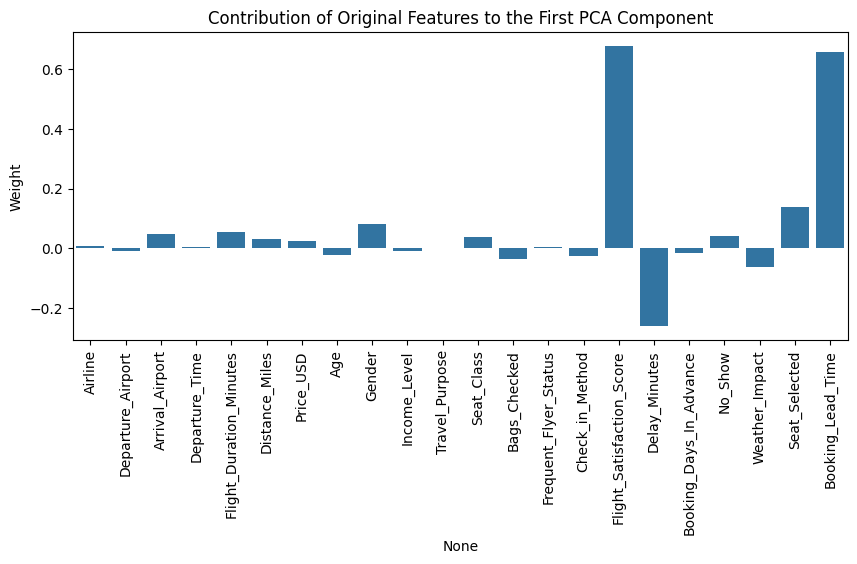

In [8]:
# 1. FEATURE EXTRACTION: PCA
n_components = 10
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_bal)
X_test_pca = pca.transform(X_test)

# Access the principal components
pca_components = pca.components_

# Print the shape of the components (n_components, n_original_features)
print("Shape of PCA components:", pca_components.shape)

plt.figure(figsize=(10, 4))
sns.barplot(x=X.columns, y=pca_components[0])
plt.title("Contribution of Original Features to the First PCA Component")
plt.xticks(rotation=90)
plt.ylabel("Weight")
plt.show()

In [9]:
# Classification on PCA features
rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train_bal)
y_pred_pca = rf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

In [10]:
# 2. FEATURE EXTRACTION: AUTOENCODER
tf.random.set_seed(42)
encoding_dim = n_components

input_dim = X_train_bal.shape[1]
input_layer = keras.layers.Input(shape=(input_dim,))
encoded = keras.layers.Dense(64, activation='relu')(input_layer)
encoded = keras.layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = keras.Model(input_layer, decoded)
encoder = keras.Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(
    X_train_bal, X_train_bal,
    epochs=30, batch_size=32, shuffle=True,
    validation_split=0.1, verbose=0
)
X_train_ae = encoder.predict(X_train_bal)
X_test_ae = encoder.predict(X_test)


2025-05-27 06:09:36.006199: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


In [11]:
# Classification on Autoencoder features
rf_ae = RandomForestClassifier(random_state=42)
rf_ae.fit(X_train_ae, y_train_bal)
y_pred_ae = rf_ae.predict(X_test_ae)
acc_ae = accuracy_score(y_test, y_pred_ae)

In [12]:
# Classification on Original Features
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train_bal, y_train_bal)
y_pred_original = rf_original.predict(X_test)
acc_original = accuracy_score(y_test, y_pred_original)

print(f"Original Features Accuracy: {acc_original:.4f}")
print(f"PCA Features Accuracy: {acc_pca:.4f}")
print(f"Autoencoder Features Accuracy: {acc_ae:.4f}")

Original Features Accuracy: 0.7990
PCA Features Accuracy: 0.7050
Autoencoder Features Accuracy: 0.6575


/tmp/ipykernel_212197/941038958.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Original", "PCA", "Autoencoder"],


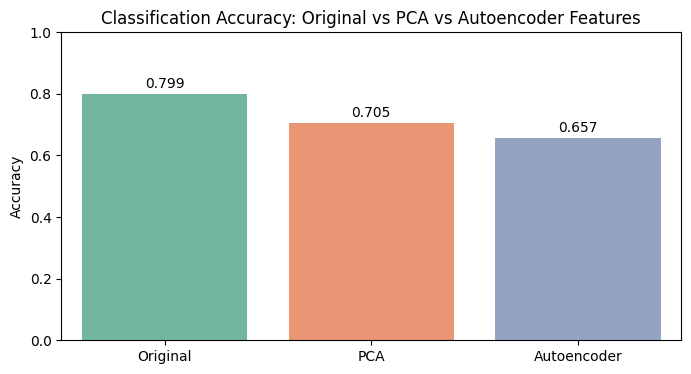

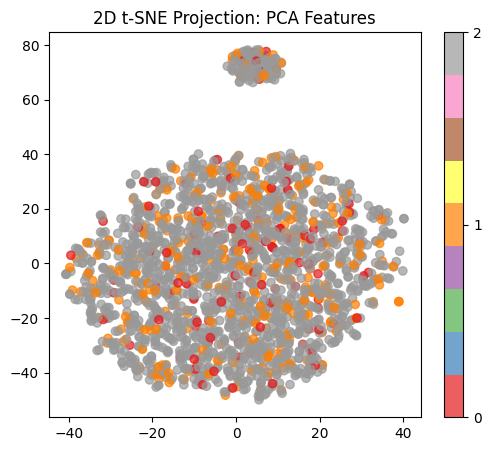

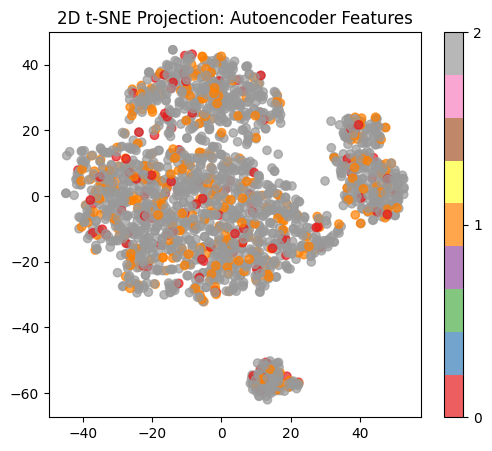

In [ ]:
# 1. Accuracy Comparison (Updated)
plt.figure(figsize=(8,4))
sns.barplot(x=["Original", "PCA", "Autoencoder"], 
           y=[acc_original, acc_pca, acc_ae], palette="Set2")
plt.title("Classification Accuracy: Original vs PCA vs Autoencoder Features")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
# Add value labels on bars
for i, v in enumerate([acc_original, acc_pca, acc_ae]):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.show()

# 2. 2D Projection (PCA vs Autoencoder)
def plot_2d_projection(X_proj, y_true, title):
    tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='pca')
    X_2d = tsne.fit_transform(X_proj)
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_true, cmap='Set1', alpha=0.7)
    plt.title(title)
    plt.colorbar(scatter, ticks=range(len(np.unique(y_true))))
    plt.show()

# t destrebuted stecastic neighbour embedding (t-SNE) for visualization
plot_2d_projection(X_test_pca, y_test, "2D t-SNE Projection: PCA Features")
plot_2d_projection(X_test_ae, y_test, "2D t-SNE Projection: Autoencoder Features")

In [14]:
print("\n=== Original Features Classification Report ===\n", classification_report(y_test, y_pred_original, target_names=le.classes_))
print("\n=== PCA Features Classification Report ===\n", classification_report(y_test, y_pred_pca, target_names=le.classes_))
print("\n=== Autoencoder Features Classification Report ===\n", classification_report(y_test, y_pred_ae, target_names=le.classes_))


=== Original Features Classification Report ===
               precision    recall  f1-score   support

   Cancelled       0.00      0.00      0.00       106
     Delayed       0.00      0.00      0.00       294
     On-time       0.80      1.00      0.89      1600

    accuracy                           0.80      2000
   macro avg       0.27      0.33      0.30      2000
weighted avg       0.64      0.80      0.71      2000


=== PCA Features Classification Report ===
               precision    recall  f1-score   support

   Cancelled       0.06      0.05      0.05       106
     Delayed       0.21      0.18      0.19       294
     On-time       0.81      0.85      0.83      1600

    accuracy                           0.70      2000
   macro avg       0.36      0.36      0.36      2000
weighted avg       0.69      0.70      0.69      2000


=== Autoencoder Features Classification Report ===
               precision    recall  f1-score   support

   Cancelled       0.05      0.07  

/home/wahaaj/WebstormProjects/MLProject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wahaaj/WebstormProjects/MLProject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wahaaj/WebstormProjects/MLProject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera